
# Modeling



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline

In [2]:
df = pd.read_csv('data/masterdf.csv')
col_to_drop = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline', 'Out Stops', 'Return Stops',
                'departure_day']
df = df.drop(col_to_drop, axis = 1)
df.head()

,Out Cities,Return Cities,Price,departure_date,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,search_day,total_stops,target
0,EWR‐SIN,SIN‐EWR,951,2022-04-10,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,4,0
1,EWR‐SIN,SIN‐EWR,979,2022-04-10,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,4,0
2,EWR‐SIN,SIN‐EWR,994,2022-04-10,2860,11:25,6:10,14,ANA,ANA,Sunday,2,1
3,EWR‐SIN,SIN‐EWR,994,2022-04-10,3155,6:30,6:10,14,ANA,ANA,Sunday,3,0
4,EWR‐SIN,SIN‐EWR,998,2022-04-10,3627,11:25,10:10,14,ANA,ANA,Sunday,3,0


In [3]:
def model_fit_print(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
    
    model.fit(X_train, y_train)
    score_matrix_printer(model, X_train, y_train, X_test, y_test)

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ------------------------------
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)

In [4]:
def grid_result(grid_model):
    print(f"""
    Optimized score and Parameters
    ==============================
    Score: {grid_model.best_score_}
    ==============================
    Parameters: {grid_model.best_params_}
    """)

In [5]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [6]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
ts = time_df['Price']
time_df = time_df.filter(['Price', 'total_duration'], axis=1)

The data is stationary with a fuller score of 0.0


Test Statistic                -1.156877e+01
p-value                        3.139122e-21
#Lags Used                     4.500000e+01
Number of Observations Used    1.888900e+04
Critical Value (1%)           -3.430696e+00
Critical Value (5%)           -2.861693e+00
Critical Value (10%)          -2.566851e+00
dtype: float64

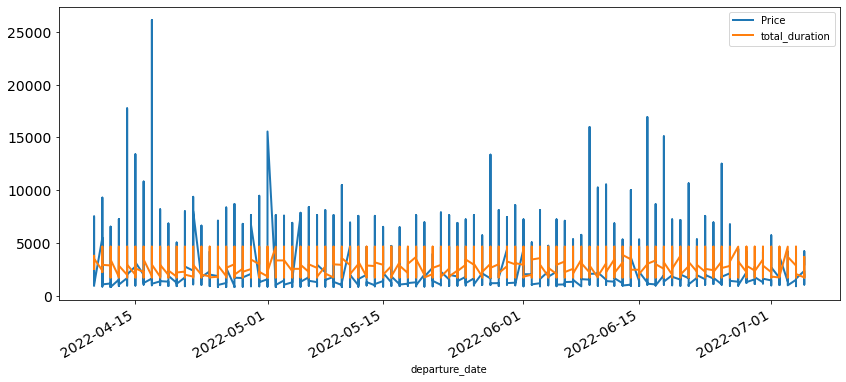

In [7]:
time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);
dicky_fuller(ts)

In [8]:
ts_daily = ts.resample('D').mean()
ts_daily

departure_date
2022-04-10    1760.088889
2022-04-11    1693.311594
2022-04-12    1584.457399
2022-04-13    1464.573913
2022-04-14    1811.731278
                 ...     
2022-07-01    1895.405797
2022-07-02    1860.350000
2022-07-03    1828.107914
2022-07-04    1754.114286
2022-07-05    1653.358696
Freq: D, Name: Price, Length: 87, dtype: float64

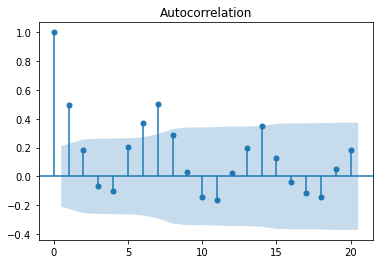

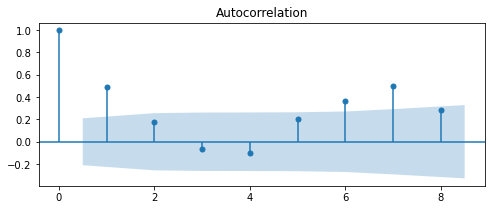

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(ts_daily)

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily, ax=ax, lags=8);

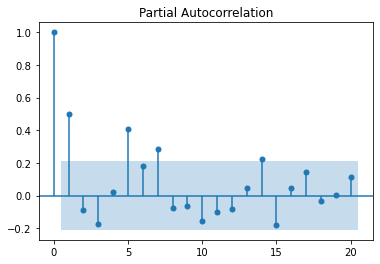

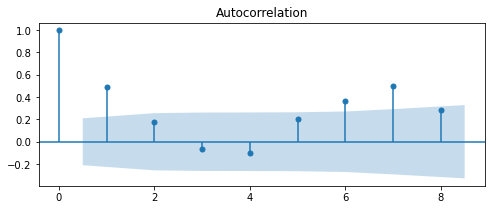

In [10]:
plot_pacf(ts_daily) #shown below is that an AR term of 1 is ideal

from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily, ax=ax, lags=8);

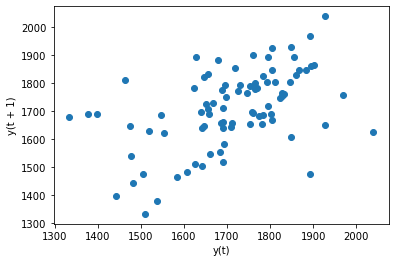

In [11]:
from pandas.plotting import lag_plot
lag_plot(ts_daily)
plt.show()

In [12]:
# from statsmodels.tsa.arima_model import ARIMA
# model = ARIMA(ts_daily, order=(1, 0, 1)) 
# results_ARIMA = model.fit()

import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(ts_daily, order=(1,0,1)).fit()
# result = model.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   87
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -540.098
Date:                Wed, 06 Apr 2022   AIC                           1088.197
Time:                        19:10:11   BIC                           1098.060
Sample:                    04-10-2022   HQIC                          1092.168
                         - 07-05-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1710.8376     26.030     65.726      0.000    1659.820    1761.855
ar.L1          0.4134      0.173      2.387      0.017       0.074       0.753
ma.L1          0.1029      0.212      0.485      0.628      -0.313       0.519
sigma2      1.451e+04   2545.115      5.702      0.000    9523.145    1.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.91   Prob(JB):                         0.27
Heteroskedasticity (H):               0.24   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model.aic

1088.196664456959

In [14]:
X = df.drop('target', axis=1)
y = df['target']

In [15]:
numeric_features = X.select_dtypes('int64')
numeric_features
ss = StandardScaler()
num_df = pd.DataFrame(ss.fit_transform(numeric_features),
                     columns = numeric_features.columns,
                     index = numeric_features.index)
num_df.head()

,Price,total_duration,record_time,total_stops
0,-0.775799,0.983102,1.522317,1.763911
1,-0.747079,0.882203,1.522317,1.763911
2,-0.731694,0.335665,1.522317,-0.159423
3,-0.731694,0.831753,1.522317,0.802244
4,-0.727591,1.625494,1.522317,0.802244


In [16]:
from sklearn.pipeline import Pipeline

In [17]:
# ColumnTransformer to handle numerics and categoricals for pipelines
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    cats = ohe.fit_transform(df_to_encode)
    cat_df = pd.DataFrame(cats,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return cat_df

def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)

In [21]:
# Baseline model
baseline = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy= 'most_frequent', random_state=32))
])

baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.9788762146176595


    Train Accuracy: 99.68%
    Train Precision: 95.94%
    ------------------------------
    Test Accuracy: 99.56%
    Test Precision: 97.59%
    


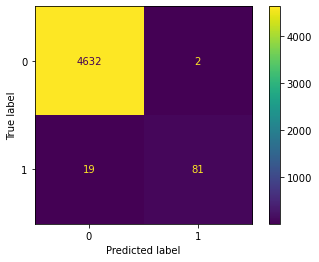

In [22]:
# Logistic Regression model
logreg_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32))
])

model_fit_print(logreg_model, X, y)

In [23]:
df['target'].value_counts(normalize=True)

0    0.979192
1    0.020808
Name: target, dtype: float64


    Train Accuracy: 98.98%
    Train Precision: 66.97%
    ------------------------------
    Test Accuracy: 98.84%
    Test Precision: 64.52%
    


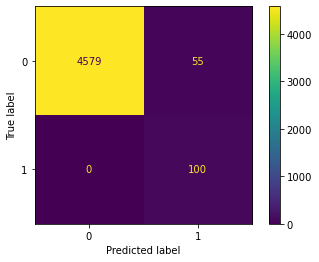

In [24]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32))
])

model_fit_print(model_1, X, y)


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 98.84%
    Test Precision: 75.28%
    


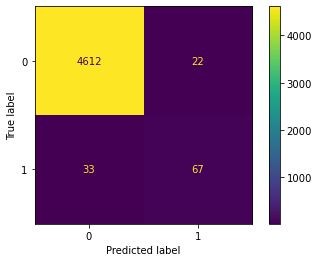

In [25]:
dtree_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(random_state=32))
])

model_fit_print(dtree_model, X, y)

In [26]:
# # Approximately 1 minute run time
# param_dict = {
#     "dtree__criterion":['gini', 'entropy'],
#     "dtree__max_depth":[1, 10, 25, 50],
#     "dtree__min_samples_split":range(1, 10),
#     "dtree__min_samples_leaf":range(1, 10)
# }

# gs = GridSearchCV(estimator=dtree_model,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   33.4s



    Optimized score and Parameters
    Score: 0.9990845318301927
    Parameters: {'dtree__criterion': 'entropy', 'dtree__max_depth': 10, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 3}
    


[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:   33.9s finished



    Train Accuracy: 99.99%
    Train Precision: 99.66%
    ------------------------------
    Test Accuracy: 99.98%
    Test Precision: 100.0%
    


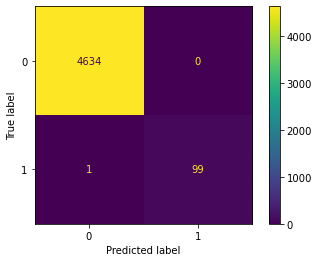

In [27]:
dtree_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_split= 3,
                                    min_samples_leaf= 1, random_state= 32))
])

model_fit_print(dtree_model2, X, y)


    Train Accuracy: 96.27%
    Train Precision: 35.68%
    ------------------------------
    Test Accuracy: 94.32%
    Test Precision: 23.34%
    


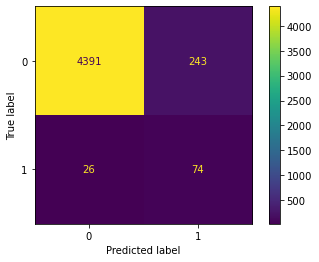

In [28]:
knn_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier())
])

model_fit_print(knn_model, X, y)

In [29]:
# # Approximately 4 minute run time
# param_dict = {
#     'knn__n_neighbors': range(5, 30),
#     'knn__metric': ['manhattan', 'minkowski', 'euclidean'],
#     'knn__weights' : ['distance', 'uniform']
# }

# gs = GridSearchCV(estimator=knn_model,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.1min



    Optimized score and Parameters
    Score: 0.9762693655774847
    Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
    


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  4.3min finished



    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 97.61%
    Test Precision: 45.39%
    


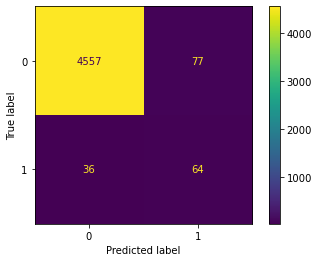

In [30]:
knn_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier(n_neighbors= 5, metric= 'manhattan', weights= 'distance'))
])

model_fit_print(knn_model2, X, y)

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=32)

kmeans.fit(X_train_clean) 

cluster_assignments = kmeans.predict(X_test_clean)

from sklearn.metrics import calinski_harabasz_score

print(calinski_harabasz_score(X_test_clean, cluster_assignments)) #higher score better

923.5819345831011


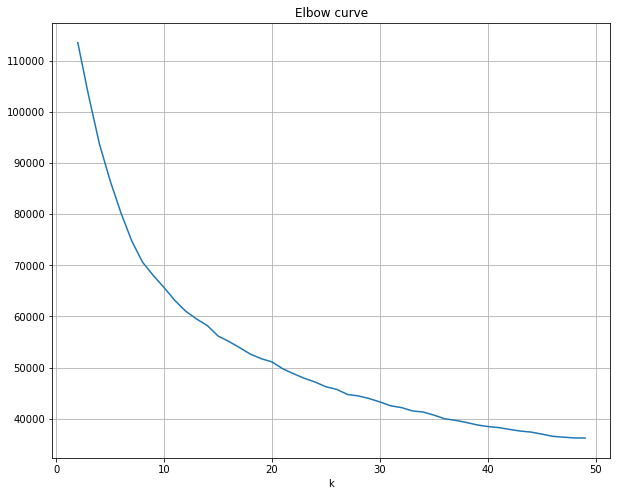

In [32]:
distortions = []

# Calculate SSE for different K
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=32)
    kmeans.fit(X_train_clean) 
    distortions.append(kmeans.inertia_)

# Plot values of SSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(range(2, 50), distortions)
ax.grid(True)

In [33]:
import sklearn.metrics as metrics

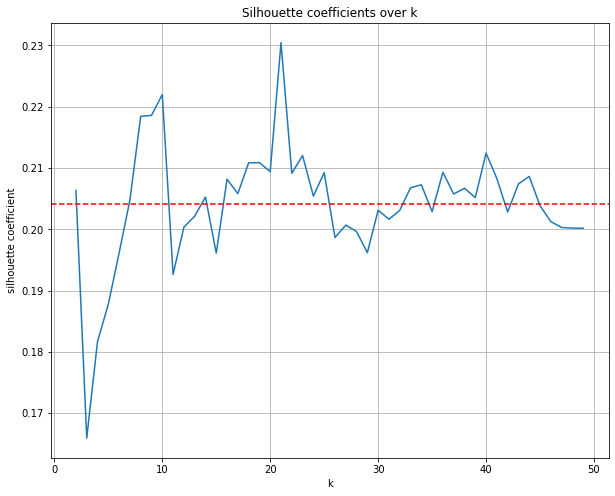

In [34]:
silhouette_plot = []
for k in range(2, 50):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X_train_clean)
    silhouette_avg = metrics.silhouette_score(X_train_clean, cluster_labels)
    silhouette_plot.append(silhouette_avg)

# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(range(2, 50), silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

In [35]:
kmeans2 = KMeans(n_clusters=22, random_state=32)

kmeans2.fit(X_train_clean) 

cluster_assignments = kmeans2.predict(X_test_clean)

from sklearn.metrics import calinski_harabasz_score

print(calinski_harabasz_score(X_test_clean, cluster_assignments)) #higher score better

439.86131891672153


In [36]:
from sklearn.ensemble import RandomForestClassifier


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 99.92%
    Test Precision: 100.0%
    


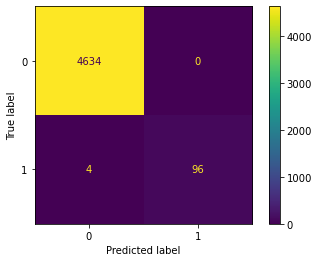

In [37]:
rforest_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(random_state = 32))
])

model_fit_print(rforest_model, X, y)

In [38]:
# # Approximately 15 minute run time
# rforest_grid = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("rf", RandomForestClassifier(random_state = 32))
# ])

# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            

# gs = GridSearchCV(estimator=rforest_grid,
#                  param_grid=param_grid,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5032 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6082 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 7232 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 8482 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 11282 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 12832 tasks    


    Optimized score and Parameters
    Score: 0.9992957994358266
    Parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 50, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
    



    Train Accuracy: 99.97%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 99.94%
    Test Precision: 100.0%
    


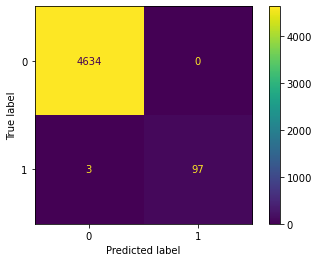

In [39]:
rforest_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 50,
                                  min_samples_leaf = 2, min_samples_split = 5, random_state = 32))
])

model_fit_print(rforest_model2, X, y)

In [40]:
from sklearn.ensemble import VotingClassifier